# **Lesson 08**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

In [2]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params
%matplotlib inline

The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on two variational parameters: $\sigma$ and $\mu$.

# Exercise 08.1

Write a Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. By using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
Note that to measure $\langle {\hat H} \rangle_T$ you need the analytical calculation of:
    
$$
\frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}
$$

### Supplementary material

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.

In [3]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

Ground state energy:  -0.4604658796926825
1st excited state energy:  0.09742471331760562
2nd excited state energy:  1.9717331343931928


## Solution

In [4]:
blocks_0_1, energy_0_1, errors_0_1 = np.loadtxt('08.1/energy_m=0.0_s=1.0.csv', delimiter=',', skiprows=1, unpack=True, usecols=(0,2,3))
blocks_1_05, energy_1_05, errors_1_05 = np.loadtxt('08.1/energy_m=1.0_s=0.5.csv', delimiter=',', skiprows=1, unpack=True, usecols=(0,2,3))

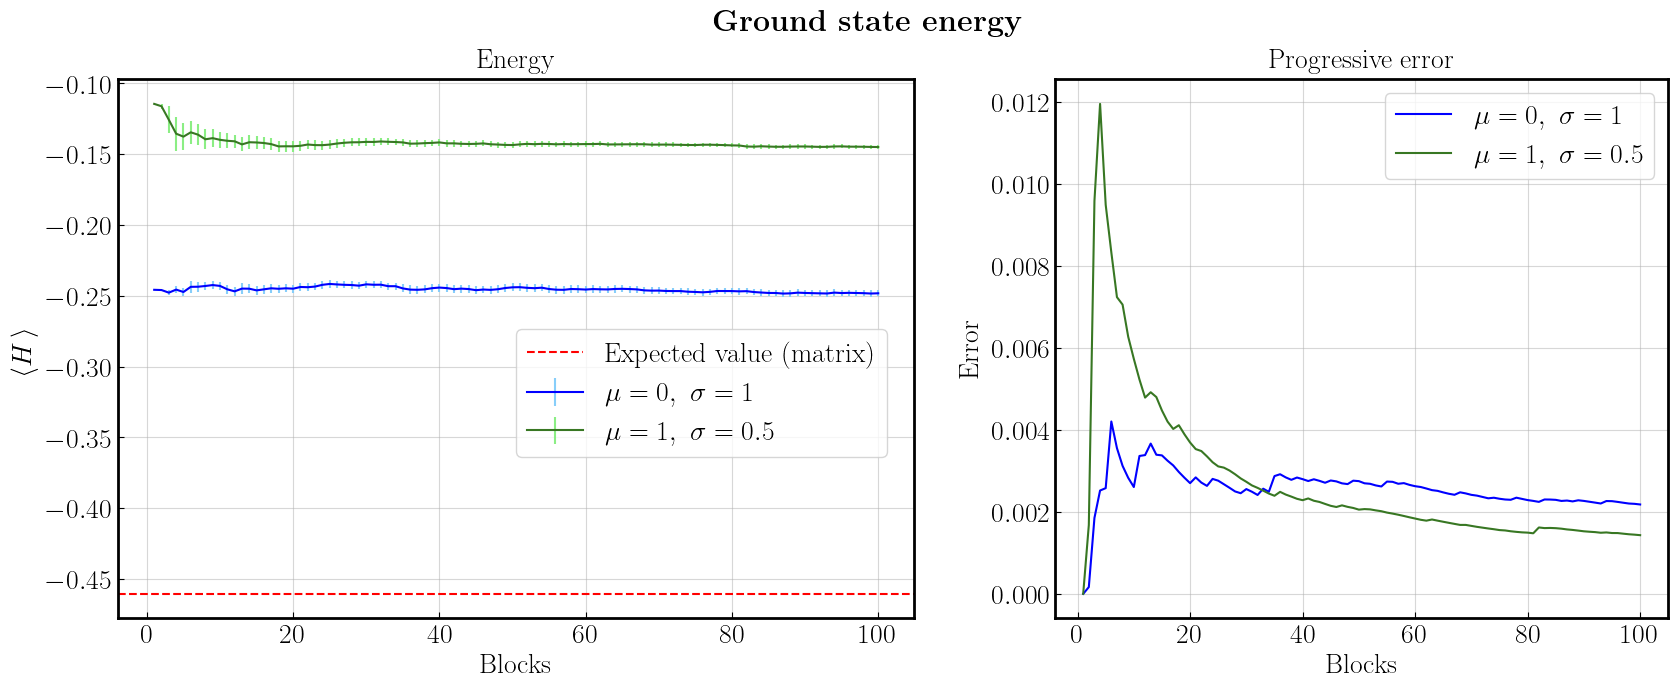

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [1.3, 1]})
fig.suptitle(r'\textbf{Ground state energy}', fontsize=22)

axs[0].errorbar(blocks_0_1, energy_0_1, yerr=errors_0_1, c='blue', ecolor='lightskyblue', label='$\mu=0, \ \sigma=1$')
axs[0].errorbar(blocks_1_05, energy_1_05, yerr=errors_1_05, c='#387723', ecolor='#8BEE84', label='$\mu=1, \ \sigma=0.5$')
axs[0].axhline(y=E[0], c='red', linestyle='--', label='Expected value (matrix)')

axs[0].set_xlabel('Blocks')
axs[0].set_ylabel(r'$\langle H \, \rangle$', labelpad=6)
axs[0].set_title('Energy', pad=8)
axs[0].legend(loc=(0.5,0.3))

axs[1].plot(blocks_0_1, errors_0_1, c='blue', label='$\mu=0, \ \sigma=1$')
axs[1].plot(blocks_1_05, errors_1_05, c='#387723', label='$\mu=1, \ \sigma=0.5$')

axs[1].set_xlabel('Blocks')
axs[1].set_ylabel('Error', labelpad=6)
axs[1].set_title('Progressive error', pad=8)
axs[1].legend()

plt.show()

In [6]:
points_0_1 = np.genfromtxt("08.1/sampling_m=0.0_s=1.0.csv", delimiter=',', skip_header=1)
points_1_05 = np.genfromtxt("08.1/sampling_m=1.0_s=0.5.csv", delimiter=',', skip_header=1)

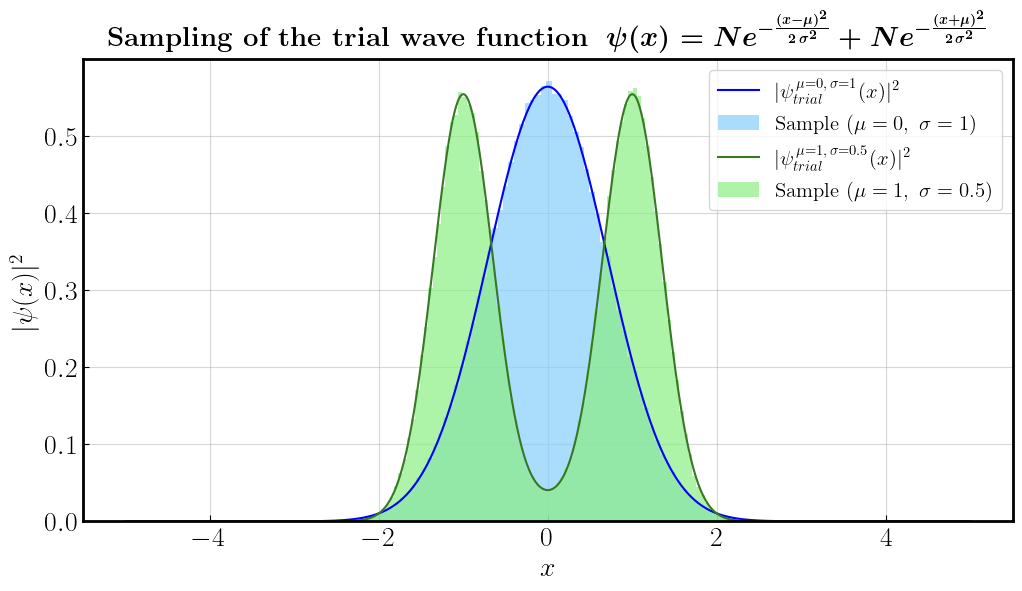

In [7]:
# plotting the sampling of the wave function
def wave_func(x, mu, sigma) :
    norm = 2 * sigma * np.sqrt(np.pi) * (1 + np.exp(-(mu**2) / (sigma**2)))
    return (1/norm) * (np.exp(-(x - mu)**2 / (2*sigma**2)) + np.exp((-(x + mu)**2 / (2*sigma**2))))**2

fig = plt.figure(figsize=(12, 6))
plt.plot(x, wave_func(x, 0, 1), c='blue', label='$|\psi_{trial}^{\, \mu=0, \, \sigma=1}(x)|^2$')
hist_0_1 = plt.hist(points_0_1, bins=100, density=True, color='lightskyblue', alpha=0.7, label="Sample $(\mu=0, \ \sigma=1)$")
plt.plot(x, wave_func(x, 1, 0.5), c='#387723', label='$|\psi_{trial}^{\, \mu=1, \, \sigma=0.5}(x)|^2$')
hist_1_05 = plt.hist(points_1_05, bins=100, density=True, color='#8BEE84', alpha=0.7, label="Sample $(\mu=1, \ \sigma=0.5)$")

plt.xlabel('$x$')
plt.ylabel('$|\psi(x)|^2$')
plt.title(r'\textbf{Sampling of the trial wave function } \boldmath $\psi(x) = Ne^{-\frac{(x-\mu)^2}{2\,\sigma^2}} + Ne^{-\frac{(x+\mu)^2}{2\,\sigma^2}}$', pad=10)
plt.legend(fontsize=15)
plt.show()

Trial wave function: 

$\psi(x) = \dfrac{1}{2  \sigma \sqrt{\pi}  \Big(1 + e^{-\frac{\mu^2}{\sigma^2}}\Big)}  \left( e^{-\frac{(x - \mu)^2}{2 \sigma^2}} + e^{-\frac{(x + \mu)^2}{2 \sigma^2}} \right)$

# Exercise 08.2

To find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$, extend your Variational Monte Carlo code to face the variational optimization problem via a Simulated Annealing (SA) algorithm.

Choose an appropriate starting temperature for your SA algorithm and an appropriate temperature-update-law to make the optimization work.

Compute $\langle {\hat H} \rangle_T$ with enough statistics in order to be able to measure the lowering of $\langle {\hat H} \rangle_T$ once the variational parameters are moved.

- Show a picture of $\langle {\hat H} \rangle_T$ (with statistical uncertainties) as a function of the SA steps of the algorithm
- you could also show a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps
- show a picture of the estimation of $\langle {\hat H} \rangle_T$ and its statistical uncertainty as a function of the number of blocks/MC steps for the set of parameters which minimize $\langle {\hat H} \rangle_T$
- show also a picture **of the sampled** $|\Psi_T(x)|^2$ by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

In [8]:
step, mu, sigma, energy_opt, err_opt = np.loadtxt('08.2/optimization.csv', delimiter=',', skiprows=1, unpack=True, usecols=(0,2,3,5,6))
blocks, energy_best, err_best = np.loadtxt('08.2/energy_best_mu=0.883_sigma=0.654.csv', delimiter=',', skiprows=1, unpack=True, usecols=(0,2,3))
sampling = np.loadtxt('08.2/sampling.csv', delimiter=',', skiprows=1, unpack=True, usecols=1)

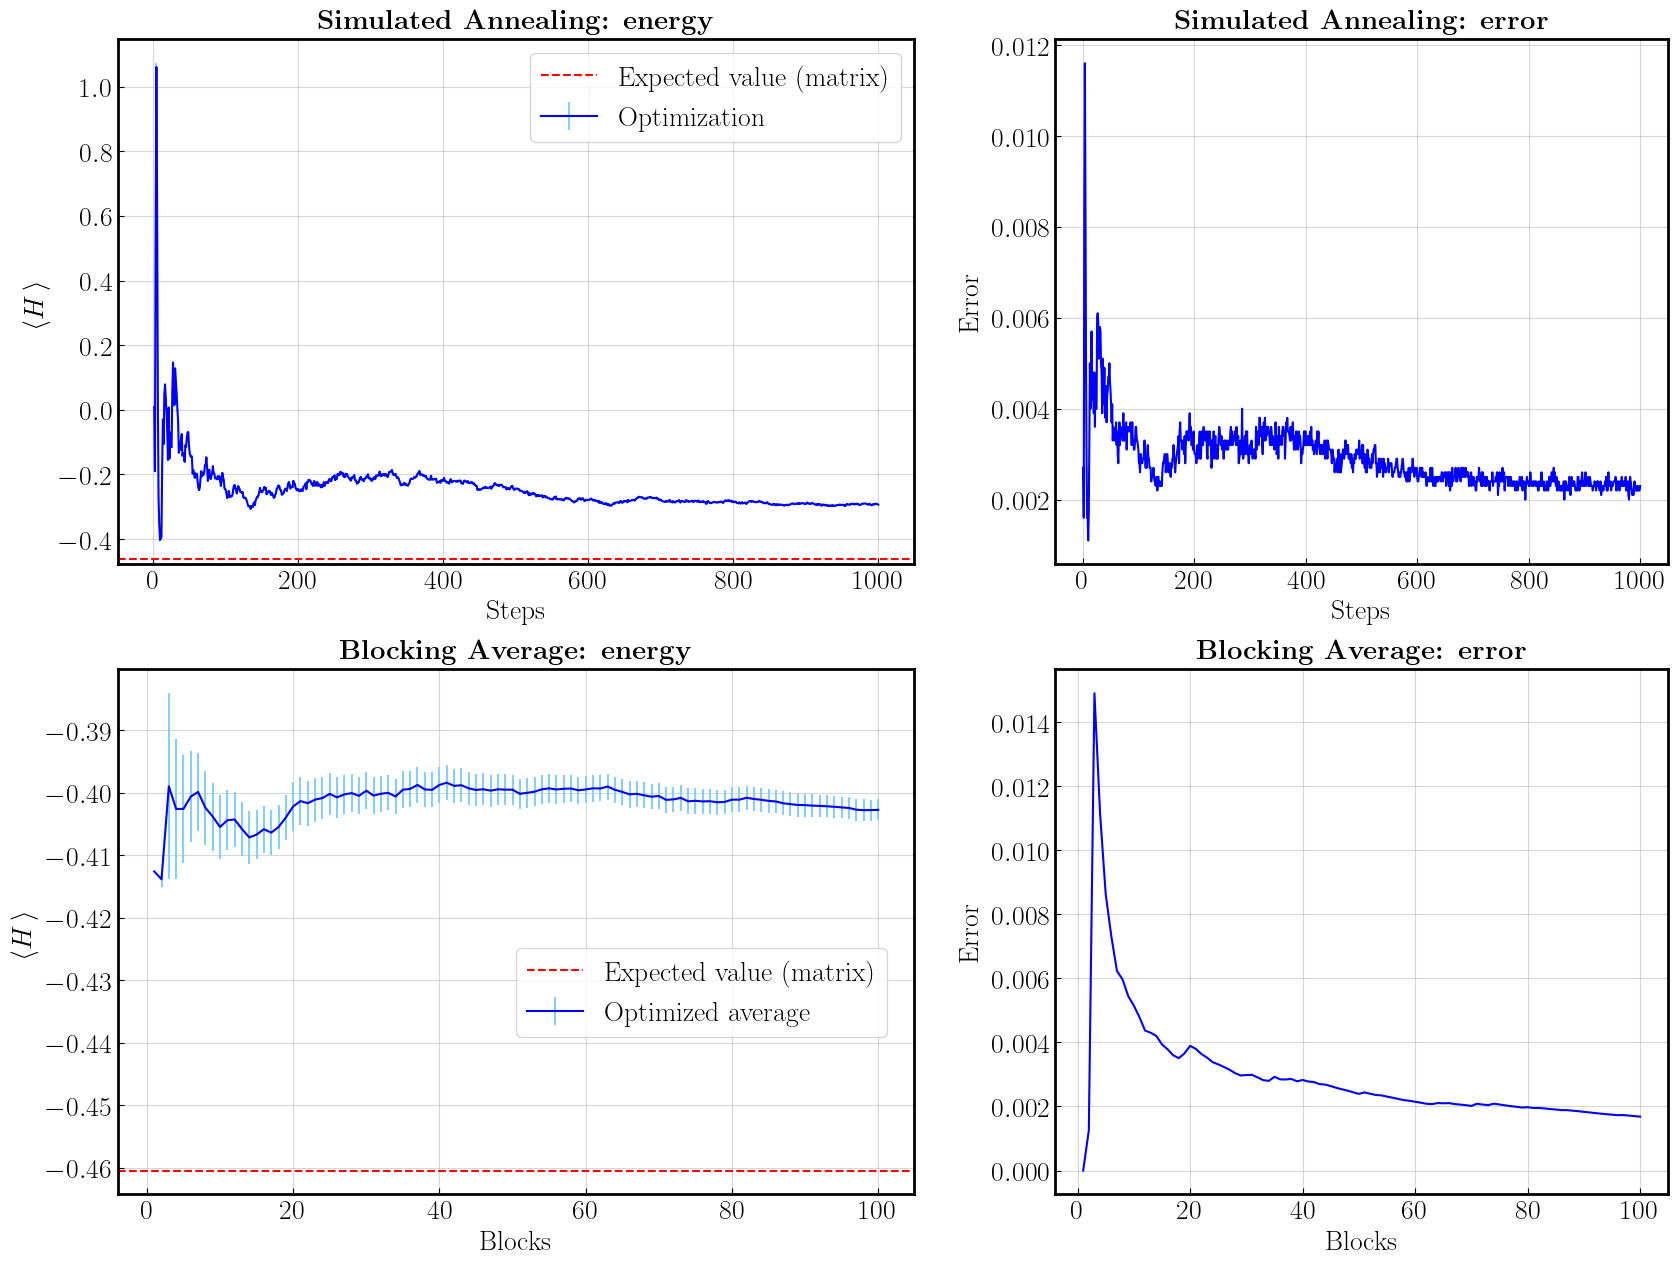

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15), gridspec_kw={'width_ratios': [1.3, 1], 'hspace': 0.2})

axs[0,0].errorbar(step, energy_opt, err_opt, c='blue', ecolor='lightskyblue', label='Optimization')
axs[0,0].axhline(y=E[0], c='red', linestyle='--', label='Expected value (matrix)')
axs[0,0].set_xlabel('Steps')
axs[0,0].set_ylabel(r'$\langle H \, \rangle$', labelpad=6)
axs[0,0].set_title(r'\textbf{Simulated Annealing: energy}', pad=8)
axs[0,0].legend()

axs[0,1].plot(step, err_opt, c='blue')
axs[0,1].set_xlabel('Steps')
axs[0,1].set_ylabel('Error', labelpad=6)
axs[0,1].set_title(r'\textbf{Simulated Annealing: error}', pad=8)

axs[1,0].errorbar(blocks, energy_best, err_best, c='blue', ecolor='lightskyblue', label='Optimized average')
axs[1,0].axhline(y=E[0], c='red', linestyle='--', label='Expected value (matrix)')
axs[1,0].set_xlabel('Blocks')
axs[1,0].set_ylabel(r'$\langle H \, \rangle$', labelpad=6)
axs[1,0].set_title(r'\textbf{Blocking Average: energy}', pad=8)
axs[1,0].legend(loc=(0.5,0.3))

axs[1,1].plot(blocks, err_best, c='blue')
axs[1,1].set_xlabel('Blocks')
axs[1,1].set_ylabel('Error', labelpad=6)
axs[1,1].set_title(r'\textbf{Blocking Average: error}', pad=8)

plt.show()

In [10]:
mu_best = 0.833
sigma_best = 0.654

Fit parametrs:
	Mu: 0.883
	Sigma: 0.654
	Normalization: 0.371
Fit function:
	$\psi(x) = \dfrac{1}{2 \cdot 0.654\cdot \sqrt{\pi} \cdot \Big(1 + e^{-\frac{0.883^2}{0.654^2}}\Big)} \cdot \left( e^{-\frac{(x - 0.883)^2}{2 \cdot0.654^2}} + e^{-\frac{(x + 0.883)^2}{2 \cdot0.654^2}} \right)$


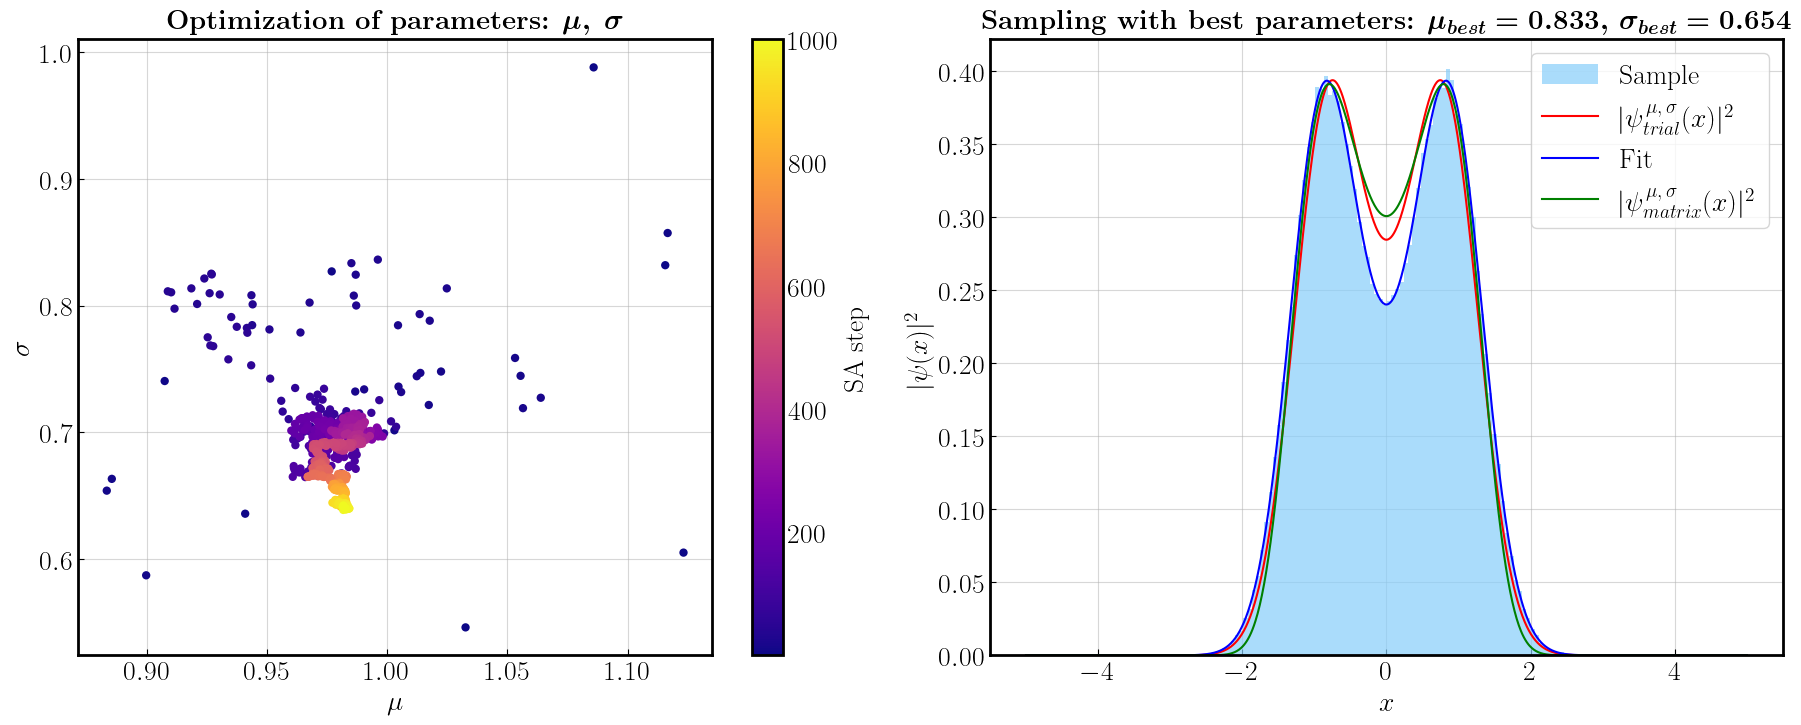

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8), gridspec_kw={'wspace': 0.15})

colors = step
scatter = axs[0].scatter(mu, sigma, c=colors, cmap='plasma', edgecolors='none')
cbar = fig.colorbar(scatter, ax=axs[0])
cbar.set_label('SA step')
axs[0].set_xlabel('$\mu$')
axs[0].set_ylabel('$\sigma$')
axs[0].set_title(r'\textbf{Optimization of parameters:} \boldmath $\mu, \ \sigma$', pad=8)

hist = axs[1].hist(sampling, bins=100, density=True, color='lightskyblue', alpha=0.7, label="Sample")
axs[1].plot(x, wave_func(x, mu_best, sigma_best), c='red', label='$|\psi_{trial}^{\, \mu, \, \sigma}(x)|^2$')
popt, pcov = curve_fit(wave_func, hist[1][:-1], hist[0])
axs[1].plot(x, wave_func(x,*popt), c='blue', label='Fit')
axs[1].plot(x, psi[0]**2, c='green', label='$|\psi_{matrix}^{\, \mu, \, \sigma}(x)|^2$')

# printing the fitted wave function
mu_fit = popt[0]
mu_str = "{:.3f}".format(mu_fit)
sigma_fit = popt[1]
sigma_str = "{:.3f}".format(sigma_fit)
norm_fit = 2 * sigma_fit * np.sqrt(np.pi) * (1 + np.exp(-(mu_fit**2) / (sigma_fit**2)))
norm_str = "{:.3f}".format(1/norm_fit)
# (1/norm) * (np.exp(-(x - mu)**2 / (2*sigma**2)) + np.exp((-(x + mu)**2 / (2*sigma**2))))**2
print('Fit parametrs:\n\tMu: ' +mu_str+ '\n\tSigma: ' +sigma_str+ '\n\tNormalization: ' +norm_str)
print('Fit function:\n\t' + r'$\psi(x) = \dfrac{1}{2 \cdot ' +sigma_str+ r'\cdot \sqrt{\pi} \cdot \Big(1 + e^{-\frac{' +mu_str+ r'^2}{' +sigma_str+ r'^2}}\Big)} \cdot \left( e^{-\frac{(x - ' +mu_str+ r')^2}{2 \cdot' +sigma_str+ r'^2}} + e^{-\frac{(x + ' +mu_str+ r')^2}{2 \cdot' +sigma_str+ r'^2}} \right)$')

axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$|\psi(x)|^2$')
axs[1].set_title(r'\textbf{Sampling with best parameters:} \boldmath $\mu_{best}=' +str(mu_best)+ ', \, \sigma_{best}=' +str(sigma_best)+ '$', pad=8)
axs[1].legend()

plt.show()

Fit: 

$\psi(x) = \dfrac{1}{2 \cdot 0.654\cdot \sqrt{\pi} \cdot \Big(1 + e^{-\frac{0.883^2}{0.654^2}}\Big)} \cdot \left( e^{-\frac{(x - 0.883)^2}{2 \cdot0.654^2}} + e^{-\frac{(x + 0.883)^2}{2 \cdot0.654^2}} \right)$
